#### Setup

In [1]:
#import pdb; pdb.set_trace()

%matplotlib inline  
import pandas as pd
import os
import re
import json
import psycopg2
from sqlalchemy.engine.url import URL

# connection to the database
# connection string for use in pandas:
con = str(URL(drivername='postgresql', 
              username=os.environ['DB_QIR_USERNAME'], 
              password=os.environ['DB_QIR_PASSWORD'], 
              host='www.quantleap.nl', 
              database='qir'))

# cursor for use with psycopg2
conn = psycopg2.connect(con)
cur = conn.cursor()  
print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


# Report data set description

The data set used in this study contains all the PDF reports published in 2017.

There are two types of reports: 
1. progress reports, containing text based on a RECOFA template
2. financial reports, containing tables - [todo: determine conformance with RECOFA template]

Most often [todo: measure] the financial reports are attached to a progress report: both are published on the same date and the identification number is equal, only the financial report has '\_B' as a postfix.

Initially we will be focussing on the progress reports as these have more structure and contain more of the data we want to retreive to answer the research questions.

## report publication over time
An overview is given on the published reports over time in the CIR register. From 2014 onwards it shows a steady flow of reports and the trend of a larger portion of financial reports attached to the progress reports, although it has not reached 100% (same amount of both progress and financial reports).

For the purpose of this study the progress reports published in 2017 will be used.

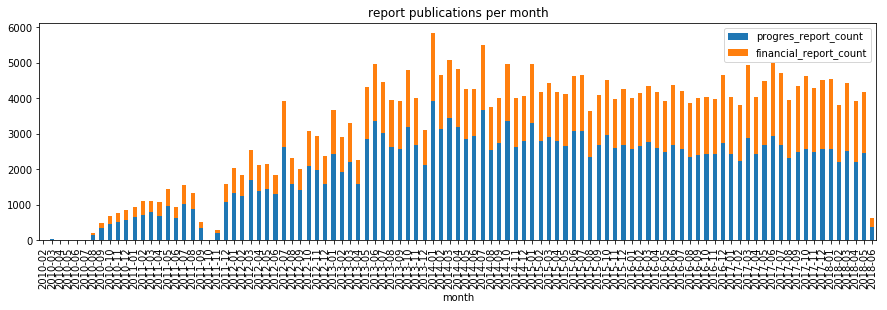

In [2]:
sql = """
with
financial as (
      select to_char(publication_date, 'YYYY-MM') as month,
             count(*) as financial_report_count
      from reports
      where right(identification, 1) = 'B'
      group by 1),
progress as (
      select to_char(publication_date, 'YYYY-MM') as month,
             count(*) as progres_report_count
      from reports
      where right(identification, 1) != 'B'
      group by 1)
select prog.month, progres_report_count, coalesce(financial_report_count, 0) as financial_report_count
  from financial fin
    full outer join progress prog on fin.month = prog.month
  order by prog.month;
"""
df = pd.read_sql(sql, con, index_col="month")
df.plot.bar(stacked=True, figsize=(15, 4), title='report publications per month')

# Completeness checks
A subselection of the published reports will be used for analysis:
- reports from 2017
- downloaded PDF reports (some cannot be downloaded anymore)
- converted instead of scanned PDFs 
- reports with extracted text (some PDF reports are encrypted or damaged (absent End of Image / End of File) and text cannot be extracted)

## PDF reports downloaded

In [3]:
sql = '''select identification, is_ocr, is_on_disk, publication_date, is_extractable
         from reports 
         where extract(year from publication_date) >= 2014
             and extract(year from publication_date) <= 2017
             and is_attachment=False;'''
df = pd.read_sql(sql, con, index_col='publication_date')

print('The dataset to be used contains {} progress reports in period 2014 - 2017'.format(len(df)))
df.head()

The dataset to be used contains 132457 progress reports in period 2014 - 2017


,identification,is_ocr,is_on_disk,is_extractable
publication_date,,,,
2016-03-16 10:05:39,13_ams_15_179_F_V_05,False,True,True
2014-07-11 16:37:06,05_gel_13_1149_F_V_03,False,True,True
2017-12-04 12:15:25,09_dha_13_781_F_V_18,False,True,True
2017-06-06 16:25:29,01_obr_15_682_F_V_08,False,True,True
2017-06-26 16:55:19,03_lim_12_381_F_V_03,False,True,True


In [4]:
total = df['identification'].resample('M').count()
total

publication_date
2014-01-31    3923
2014-02-28    3138
2014-03-31    3441
2014-04-30    3195
2014-05-31    2843
2014-06-30    2944
2014-07-31    3662
2014-08-31    2548
2014-09-30    2739
2014-10-31    3359
2014-11-30    2634
2014-12-31    2793
2015-01-31    3295
2015-02-28    2782
2015-03-31    2922
2015-04-30    2783
2015-05-31    2663
2015-06-30    3066
2015-07-31    3078
2015-08-31    2342
2015-09-30    2671
2015-10-31    2966
2015-11-30    2589
2015-12-31    2696
2016-01-31    2564
2016-02-29    2641
2016-03-31    2766
2016-04-30    2602
2016-05-31    2485
2016-06-30    2693
2016-07-31    2574
2016-08-31    2338
2016-09-30    2408
2016-10-31    2438
2016-11-30    2421
2016-12-31    2750
2017-01-31    2430
2017-02-28    2232
2017-03-31    2886
2017-04-30    2426
2017-05-31    2684
2017-06-30    2942
2017-07-31    2682
2017-08-31    2319
2017-09-30    2480
2017-10-31    2581
2017-11-30    2479
2017-12-31    2564
Freq: M, Name: identification, dtype: int64

In [5]:
df_on_disk = df[df.is_on_disk == True]
on_disk = df_on_disk.is_on_disk.resample('M').count()
on_disk

publication_date
2014-01-31    3923
2014-02-28    3138
2014-03-31    3440
2014-04-30    3195
2014-05-31    2843
2014-06-30    2944
2014-07-31    3662
2014-08-31    2548
2014-09-30    2739
2014-10-31    3355
2014-11-30    2634
2014-12-31    2793
2015-01-31    3295
2015-02-28    2782
2015-03-31    2922
2015-04-30    2783
2015-05-31    2663
2015-06-30    3066
2015-07-31    3078
2015-08-31    2340
2015-09-30    2670
2015-10-31    2966
2015-11-30    2589
2015-12-31    2696
2016-01-31    2564
2016-02-29    2641
2016-03-31    2726
2016-04-30    2601
2016-05-31    2483
2016-06-30    2671
2016-07-31    2574
2016-08-31    2335
2016-09-30    2392
2016-10-31    2427
2016-11-30    2418
2016-12-31    2646
2017-01-31    1791
2017-02-28    1975
2017-03-31    2886
2017-04-30    2426
2017-05-31    2684
2017-06-30    2942
2017-07-31    2682
2017-08-31    2319
2017-09-30    2480
2017-10-31    2581
2017-11-30    2459
2017-12-31    2564
Freq: M, Name: is_on_disk, dtype: int64

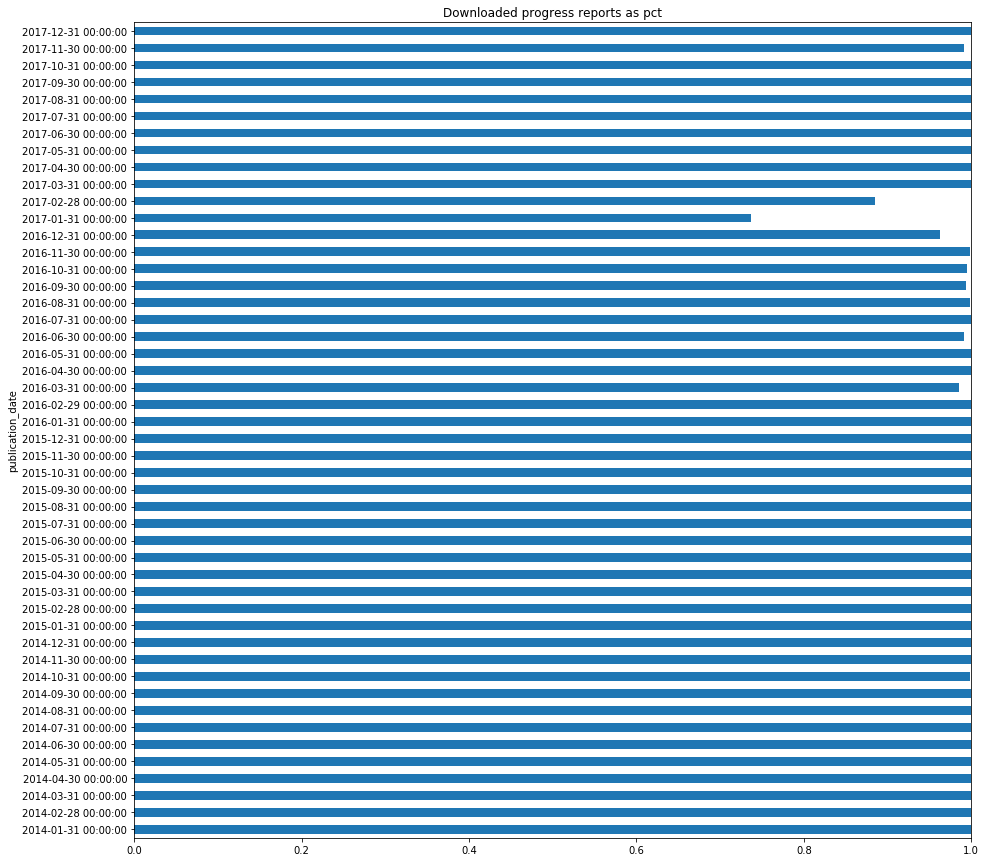

In [6]:
(on_disk / total).plot.barh(title='Downloaded progress reports as pct', xlim=[0,1], figsize=(15, 15))

Results: The chart shows download percentage **for all** insolvents. Effort will be put into making this set complete **for active insolvents**. Not all reports are downloaded/retrieved for the 2017 dataset. 

## PDF Conversion of progress reports on disk

PDFs can be generated by:
1. scanning printed pages - resulting in an image only document, 
2. converting a document to PDF - resulting in a text only document
3. scanning printed pages with OCR (Optical Character Recognition) - resulting in a text and image document

The latter one can have discrepancies between the visible text and extracted text.

In [7]:
df_on_disk_and_not_scanned = df_on_disk[df_on_disk.is_ocr == False]
on_disk_and_not_scanned = df_on_disk_and_not_scanned['is_ocr'].resample('M').count()
on_disk_and_not_scanned

publication_date
2014-01-31    1496
2014-02-28    1292
2014-03-31    1275
2014-04-30    1185
2014-05-31    1160
2014-06-30    1141
2014-07-31    1616
2014-08-31    1091
2014-09-30    1121
2014-10-31    1467
2014-11-30    1127
2014-12-31    1154
2015-01-31    1603
2015-02-28    1236
2015-03-31    1274
2015-04-30    1115
2015-05-31    1267
2015-06-30    1476
2015-07-31    1420
2015-08-31    1161
2015-09-30    1281
2015-10-31    1485
2015-11-30    1411
2015-12-31    1367
2016-01-31    1475
2016-02-29    1539
2016-03-31    1627
2016-04-30    1557
2016-05-31    1497
2016-06-30    1804
2016-07-31    1743
2016-08-31    1559
2016-09-30    1690
2016-10-31    1788
2016-11-30    1862
2016-12-31    1873
2017-01-31       1
2017-02-28     957
2017-03-31    2349
2017-04-30    2136
2017-05-31    2306
2017-06-30    2614
2017-07-31    2341
2017-08-31    2102
2017-09-30    2221
2017-10-31    1858
2017-11-30    1300
2017-12-31    2284
Freq: M, Name: is_ocr, dtype: int64

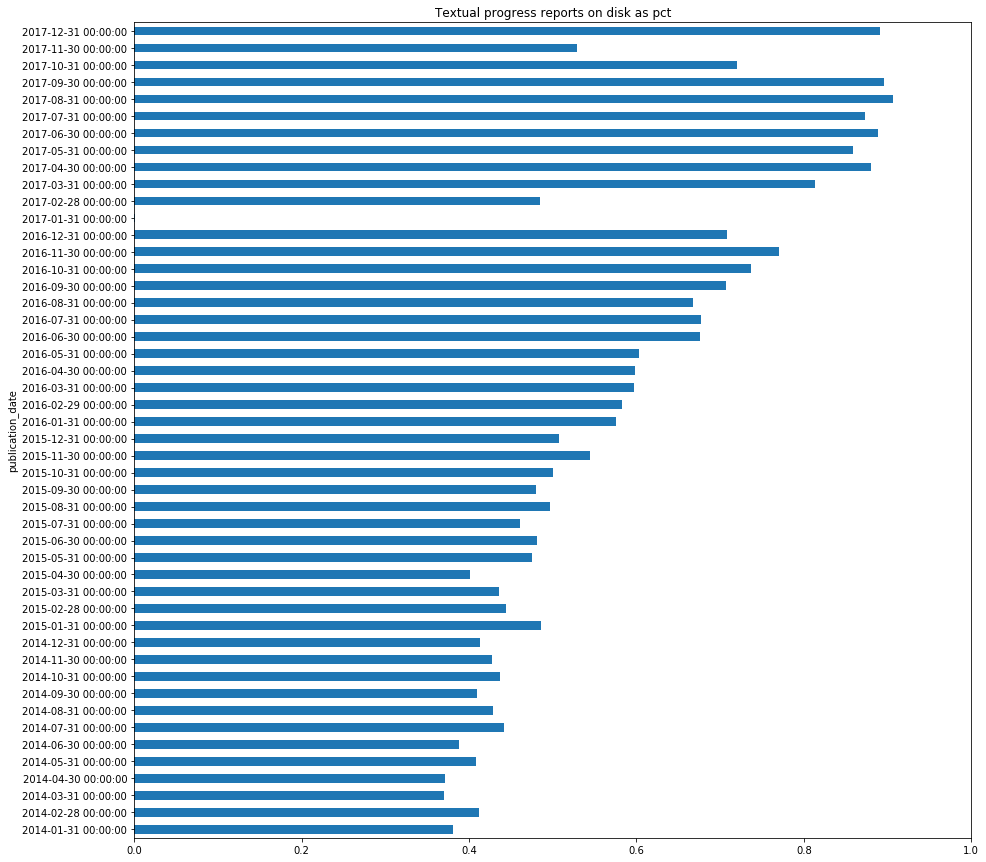

In [8]:
(on_disk_and_not_scanned / on_disk).plot.barh(title='Textual progress reports on disk as pct', xlim=[0,1], figsize=(15, 15))

## Textual progress reports on disk with extracted text

In [9]:
df_is_extractable = df_on_disk_and_not_scanned[df_on_disk_and_not_scanned.is_extractable == True]
is_extractable = df_is_extractable.is_extractable.resample('M').count()
is_extractable

publication_date
2014-01-31    1480
2014-02-28    1281
2014-03-31    1250
2014-04-30    1156
2014-05-31    1121
2014-06-30    1077
2014-07-31    1585
2014-08-31    1058
2014-09-30    1098
2014-10-31    1430
2014-11-30    1080
2014-12-31    1130
2015-01-31    1575
2015-02-28    1206
2015-03-31    1229
2015-04-30    1090
2015-05-31    1237
2015-06-30    1441
2015-07-31    1382
2015-08-31    1136
2015-09-30    1251
2015-10-31    1453
2015-11-30    1369
2015-12-31    1345
2016-01-31    1459
2016-02-29    1513
2016-03-31    1617
2016-04-30    1532
2016-05-31    1486
2016-06-30    1785
2016-07-31    1715
2016-08-31    1548
2016-09-30    1670
2016-10-31    1770
2016-11-30    1847
2016-12-31    1814
2017-01-31       1
2017-02-28     945
2017-03-31    2327
2017-04-30    2120
2017-05-31    2290
2017-06-30    2600
2017-07-31    2289
2017-08-31    2088
2017-09-30    2210
2017-10-31    1848
2017-11-30    1291
2017-12-31    2271
Freq: M, Name: is_extractable, dtype: int64

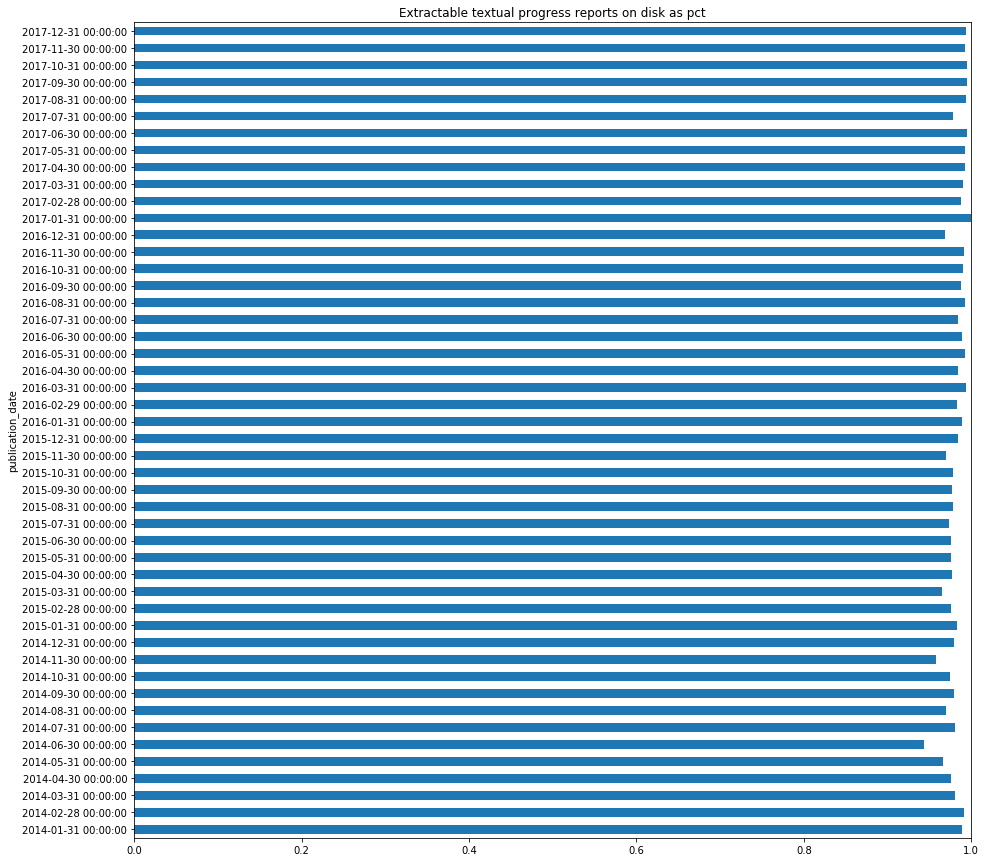

In [10]:
(is_extractable / on_disk_and_not_scanned).plot.barh(title='Extractable textual progress reports on disk as pct', xlim=[0,1], figsize=(15, 15))

### Completeness total funnel

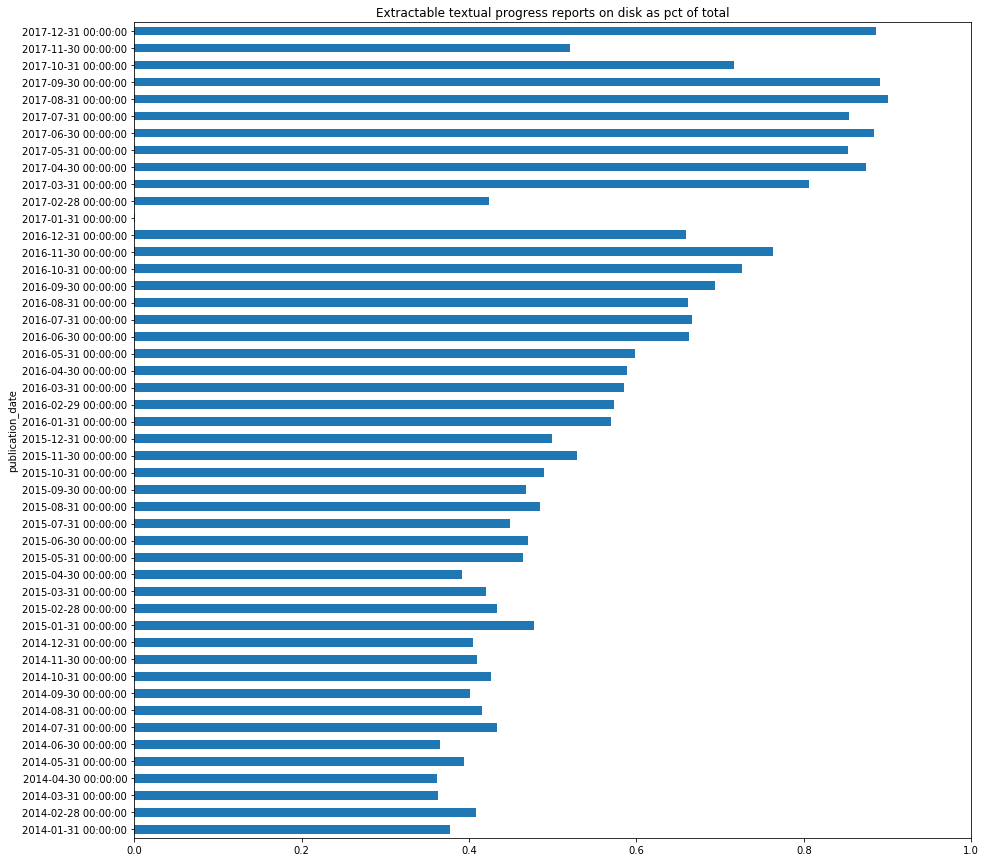

In [11]:
(is_extractable / total).plot.barh(title='Extractable textual progress reports on disk as pct of total', xlim=[0,1], figsize=(15, 15))

## Search in progress reports.

There are three search objectives, each more scoped: 
1. to enable full text search over the whole report
2. to enable faceted search by heading section
3. to extract specific data points as value. 

### Full Text Search
The extracted contents is made searchable using the postgres full text search functionality. (https://www.postgresql.org/docs/9.6/static/textsearch.html)

### Faceted search
The progress reports should be structured in sections according to RECOFA guidelines, see **model-verslag-faillissement-rechtspersoon.pdf**. We like to be able to specificly perform full text search in one of the sections.

### data points wish list
We like to extract specific data point values from the reports. A wish list is given below:

Algemeen
- Personeel gemiddeld aantal: **aantal**
- Bestede uren totaal: **aantal**
- Saldo boedelrekening: **bedrag**


4 Debiteuren

4.2 Opbrengst: **bedrag**


7 Rechtmatigheid

7.2 Depot jaarrekeningen: **wel/niet**

7.5 Onbehoorlijk bestuur: **wel/niet**


8 Crediteuren

8.1 Boedelvorderingen: bedrag (salaris curator / UWV / ..)

8.2 Preferente vorderingen van de fiscus: **bedrag**

8.3 Preferente vorderingen van het UWV: **bedrag**

8.4 Andere preferente vorderingen: **bedrag**

8.5 Aantal concurrente crediteuren: **bedrag**

8.6 Bedrag concurrente crediteuren: **bedrag**

#### Enige terloopse bevindingen en issues
- Bij insolventen van verslagen 13_ams_15_478_F_V_06 en 10_rot_12_90_F_V_16 zijn geen enkele financiele verslagen ook curator salaris wordt niet genoemd. Vraag: wie levert geen financieel verslag en waarom?
- Bij eindverslag 10_rot_14_1054_F_V_10 staat curator salaris alleen in de financiele bijlage. Er lijkt ook sprake van een schikking - regeling bestuurder: 22.000 - wegens rechtmatigheidsissue. 
- bij 11_rot_12_41_F_V_15 staan bedragen doorgestreept, textconversie pakt dat niet
- De eindverslagen zijn niet echt eindverslagen: 'Naar verwachting zal het faillissement in de komende
verslagperiode eindigen.' (11_rot_12_41_F_V_15)
- uurtarief bij 11_rot_12_41_F_V_15 komt op 280,-
- 10_rot_14_1054_F_V_10, 01_obr_13_293_F_V_09 omzetting pdf>txt verliest letters/gegevens/structuur met PDFMiner. Welke converter pakt dit goed aan ?
- Strikethrough in PDF komt niet terug in de tekstconversie en dit betekent vaak het tegenovergestelde.
- PDFMiner wisselt soms woordvolgorde en mangled soms letters ook al staat dit duidelijk in het PDF. Dit komt door het formaat: text plus image overlay.
- PyPDF2 hangt op grote images (voorbeelden '16_mne_13_935_F_V_13', '16_mne_13_1055_F_V_13', '16_mne_12_331_F_V_15', '16_mne_12_326_F_V_15', '16_mne_12_327_F_V_15,' '16_mne_12_384_F_V_15') - een pull request #329 fixt dit.

### Faceted search - section extraction
The RECOFA model progress report contains the following sections to be extracted:

Step 1: extract section anchor points from progress reports, the level 2 headings
To extract the introduction we can extract between the beginning and level 1 heading 1.

Step 2: extract candidate sections from model report

In [37]:
sql = '''SELECT identification, content
         FROM reports 
         WHERE extract(year from publication_date) >= 2014
             AND extract(year from publication_date) <= 2017
             AND is_attachment = FALSE
             AND is_ocr = FALSE 
             AND is_extractable = TRUE
             AND content IS NOT NULL
         ORDER BY publication_date ASC
         LIMIT 1000;'''
df = pd.read_sql(sql, con, index_col='identification')
df.head(n=10)

,content
identification,
17_nne_13_98_F_V_04,Winkel \n\nadvocatenkantoor \n\n nummer: 4 ;...
17_nne_13_345_F_V_01,Naam faill Voercentrum Franchise BV \nC 17/13/...
17_nne_13_344_F_V_01,Naam faill Voercentrum Grondstoffen BV \nC 17/...
17_nne_13_346_F_V_01,Naam faill Voercentrum Dokkum BV \nC 17/13/346...
17_nne_13_342_F_V_01,\n\n Nummer: 1 \n\n Datum: 27 dece...
17_nne_13_343_F_V_01,Naam faill Voercentrum BV \nC 17/13/343 F \n \...
08_ove_13_352_F_V_03,\n\n \n \n\nFAILLISSEMENTSVERSLAG - 03 \n\nop...
10_rot_13_931_F_V_02,Borsboom & Hamm \n\na d v o c a t en \n\nHet p...
03_lim_13_41_F_V_02,\n \n \n \n\nmr M.T.A.C. Russel \nde heer P.E...


In [13]:
# Step 1: extract section anchor points from progress reports
# Sub step: extract candidate sections from model report
model_content = open('model-verslag-faillissement-rechtspersoon.txt', 'r').read()

def match_headings(content, level=2):
    """ returns level 2 (e.g. 1.1) heading matches as tuple (heading number, heading title)"""
    flags = re.MULTILINE
    if level == 2:
        pattern = r"^\s*(\d{1,2}\.\d{1,2})\s*(.*)$"
    elif level == 12:  # level 1 and level 2
        pattern = r"^\s*(\d{1,2}\.\d{0,2})\s*(.*)$"
    else:
        raise NotImplementedError
    match = re.findall(pattern, content, flags)
    return match if match is not None else []

model_headings = [('0.0', 'Introduction')] + match_headings(model_content, level=2)
model_heading_numbers = list(zip(*model_headings))[0]
print(len(model_headings))
model_headings

73


[('0.0', 'Introduction'),
 ('1.1', 'Directie en organisatie'),
 ('1.2', 'Winst en verlies'),
 ('1.3', 'Balanstotaal'),
 ('1.4', 'Lopende procedures'),
 ('1.5', 'Verzekeringen'),
 ('1.6', 'Huur'),
 ('1.7', 'Oorzaak faillissement'),
 ('2.1', 'Aantal ten tijde van faillissement'),
 ('2.2', 'Aantal in jaar voor faillissement'),
 ('2.3', 'Datum ontslagaanzegging'),
 ('2.4', 'Werkzaamheden'),
 ('3.1', 'Beschrijving'),
 ('3.2', 'Verkoopopbrengst'),
 ('3.3', 'Hoogte hypotheek'),
 ('3.4', 'Boedelbijdrage'),
 ('3.5', 'Werkzaamheden'),
 ('3.6', 'Beschrijving'),
 ('3.7', 'Verkoopopbrengst'),
 ('3.8', 'Boedelbijdrage'),
 ('3.9', 'Bodemvoorrecht fiscus'),
 ('3.10', 'Werkzaamheden'),
 ('3.11', 'Beschrijving'),
 ('3.12', 'Verkoopopbrengst'),
 ('3.13', 'Boedelbijdrage'),
 ('3.14', 'Werkzaamheden'),
 ('3.15', 'Beschrijving'),
 ('3.16', 'Verkoopopbrengst'),
 ('3.17', 'Werkzaamheden'),
 ('4.1', 'Omvang debiteuren'),
 ('4.2', 'Opbrengst'),
 ('4.3', 'Boedelbijdrage'),
 ('4.4', 'Werkzaamheden'),
 ('5.1', 'Vo

In [14]:
# Example (first) report
report_content = df['content'][0]
report_headings = match_headings(report_content, level=12)  # match level 2 headings
report_heading_numbers = list(zip(*report_headings))[0]
print(report_content)
print(report_headings)

Naam faill Voercentrum BV 
C 17/13/343 F 
 

 
 
 
 
  
 
 
 
 
 

 
 
 
 

 
 
 
 
 

Faillissementsnummer 
Datum uitspraak 
Curator  
 
 
 
 
Rechter-commissaris 
 
Activiteiten onderneming 

 

Omzetgegevens  
 
Personeel gemiddeld aantal 
 

 

      Nummer: 1   

     Datum: 27 december 2013 

FAILLISSEMENTSVERSLAG       
 
 
In dit verslag  worden  de  werkzaamheden en de stand van de boedel beschreven  over de afgelopen 
periode.  De  curator  baseert  zich  op  aangetroffen  gegevens  en  informatie  van  derden.  De  juistheid 
daarvan  staat  thans  nog  niet  vast,  zodat  mogelijkerwijs  gegevens  en  cijfers  in  een  later  stadium 
aanpassing  behoeven.  Aan  dit  verslag  kunnen  geen  rechten  worden  ontleend.  De  inhoud  van  de 
papieren versie is identiek aan de digitale versie. 
 
 
Gegevens gefailleerde 

: 

de besloten vennootschap VOERCENTRUM B.V., tevens 
handelend  onder  de  naam  FEEDCENTER  (hierna:  “de 
vennootschap”) 
 
Statutair en vestigingsadres: 


In [15]:
# SECTIONS
# check hoeveel er exact matchen(ignore case)
# check hoeveel er op heading nummers matchen
# for stop anchor point we need to level 1 headings too

# ZOU MATCH OP HEADING NUMMER AL GENOEG KUNNEN ZIJN ? :
# check of heading nummers oplopen
# check of heading nummers in kandidatenlijst voorkomen

# level 1 pattern with .? yields many false positives (in first examined case)

def is_strictly_increasing_heading_numbers(heading_numbers):
    """ checks if all level 2 headings 1.1, 1.2, 3.1 etc in list are strictly increasing. """
    return all([float(a) < float(b) for (a, b) in zip(heading_numbers, heading_numbers[1:])])

def has_only_model_heading_numbers(report_heading_numers):
    """ checks if report heading numbers are all present in the model heading numbers. """
    return set(report_heading_numers) <= set(model_heading_numbers)

def get_heading_numbers(content):
    headings = match_headings(content)
    if headings:
        heading_numbers, _ = list(zip(*headings))
        return heading_numbers
    else:
        return []
  
def model_heading_coverage(report_heading_numbers):
    """ return the number of headings found as percentage of the model report. """
    pass

In [25]:
%run progress_report_extractor
report_content = df['content'][0]
print(extract_section(report_content, '7.6'))  # paulianeus handelen

 
 
Tot op heden is van paulianeus handelen nog niet gebleken. 
 
 
 
In de achterliggende verslagperiode  zijn nog geen noemenswaardige  werkzaamheden verricht op dit 
onderdeel.  
 


In [50]:
# make sections columns in the dataframe - capture section content and length
%run progress_report_extractor
extractor = ProgressReportSectionExtractor()
sections = ['7.6']  # extractor.sections.keys()  # all available sections
for section in sections:
    section_column = extractor.section_id(section)
    df[section_column] = df['content'].apply(lambda x: extract_section(x, section))
    df[section_column+'_length'] = df[section_column].str.len()
df.head(20)

Paulianeus handelen 
Op 16 juni 2011 heeft De Koning, de onderneming van Billabong (goodwill, handelsnaam, 
voorraden en exploitatierechten) gekocht voor een bedrag van € 120.000. Op 12 maart 2012 
heeft De Koning de hele onderneming van Billabong (goodwill en inventaris) weer verkocht aan 
een derde voor een bedrag van € 90.000. De curator  heeft deze verkoop onderzocht en is tot 
de conclusie gekomen dat er geen sprake is van paulianeus handelen.  
 
 
 
 
 




,content,paulianeus_handelen,paulianeus_handelen_length
identification,,,
17_nne_13_98_F_V_04,Winkel \n\nadvocatenkantoor \n\n nummer: 4 ;...,None,NaN
17_nne_13_345_F_V_01,Naam faill Voercentrum Franchise BV \nC 17/13/...,\n \nTot op heden is van paulianeus handelen ...,179.0
17_nne_13_344_F_V_01,Naam faill Voercentrum Grondstoffen BV \nC 17/...,\n \nTot op heden is van paulianeus handelen ...,179.0
17_nne_13_346_F_V_01,Naam faill Voercentrum Dokkum BV \nC 17/13/346...,\n \nTot op heden is van paulianeus handelen ...,179.0
17_nne_13_342_F_V_01,\n\n Nummer: 1 \n\n Datum: 27 dece...,\n \nTot op heden is van paulianeus handelen ...,179.0
17_nne_13_343_F_V_01,Naam faill Voercentrum BV \nC 17/13/343 F \n \...,\n \nTot op heden is van paulianeus handelen ...,183.0
08_ove_13_352_F_V_03,\n\n \n \n\nFAILLISSEMENTSVERSLAG - 03 \n\nop...,Paulianeus handelen \n\nNog niet onderzocht. ...,294.0
10_rot_13_931_F_V_02,Borsboom & Hamm \n\na d v o c a t en \n\nHet p...,None,NaN
03_lim_13_41_F_V_02,\n \n \n \n\nmr M.T.A.C. Russel \nde heer P.E...,Paulianeus handelen \nVoor zover ik tot op...,138.0


In [51]:
# empty section percentages - no match 
df[[col for col in list(df) if 'length' not in col]].isnull().sum()/df.shape[0]*100

content                 0.0
paulianeus_handelen    13.9
dtype: float64

In [ ]:
# Result: better adherence to the model report over time

earliers 200 reports in 2014, pct of empty sections:
introduction                          21.0
directie_en_organisatie               25.5
oorzaak_faillissement                 34.5
aantal_ten_tijde_van_faillissement    38.5
boekhoudplicht                        27.0
onbehoorlijk_bestuur                  26.0
paulianeus_handelen                   93.0
boedelvorderingen                     10.5
pref_vord_van_de_fiscus                9.0
pred_vord_van_het_uwv                 13.0
andere_pred_crediteuren               14.5
aantal_concurrente_crediteuren        14.5
bedrag_concurrente_crediteuren        16.0

most recent 200 reports in 2017 pct of empty sections:
content                               0.0
introduction                          2.0
directie_en_organisatie               2.5
oorzaak_faillissement                 8.5
aantal_ten_tijde_van_faillissement    3.0
onbehoorlijk_bestuur                  7.5
paulianeus handelen                   7.0
boekhoudplicht                        8.0
paulianeus_handelen                   7.0
boedelvorderingen                     5.0
pref_vord_van_de_fiscus               5.0
pred_vord_van_het_uwv                 6.0
andere_pred_crediteuren               6.5
aantal_concurrente_crediteuren        6.5
bedrag_concurrente_crediteuren        6.0



#### Results
Edge cases are identified that result in empty sections:

1. Empty sections can be caused when the subsequent heading two level does not exists, e.g. search of section 7.6 between 7.6-7.7 is not found when 7.7 is left out. The subsequent level 2 (7.8) or level 1 (8) is given as alternatives. (see: 17_nne_13_343_F_V_01)

2. Empty sections can be caused when the heading 2 does not contain the heading 1, e.g. heading 2.1 is given as 2. (see: 03_lim_13_41_F_V_02 directie en organisatie)

3. Empty sections can be caused when there is no subheading information at all but the main headings are correct (see: 03_lim_13_41_F_V_02 paulianeus handelen).

4. Empty sections can be caused when the heading information does not correspong with the model report (see: 05_gel_12_200_F_V_06 paulianeus handelen where the heading is 3.2 instead of 7.6)

5. Empty sections can be caused when textual elements have been reshuffled (see 05_gel_12_600_F_V_04, paulianeus handelen where heading 7 is placed under the heading 7 section, the PDF looks good but exracted text shows shuffle). Maybe pdftotext --layout will fix this. 


Addressing edge cases by supplying additional regex rules diminishes the pct of empty sections. We could set a target for the pct.

Truly empty sections:
**column Directie en organisatie**: All five 2017 inspected documents with no section content for 1.1 did indeed not contain that section. This section is apparently covered in the first report(s) and not repeated later. It is assumed to be the case for many reports. Some reports will only append text, thus repeating the previous content.

In [52]:
# inspect Nones when heading/keyword is present
df[df['paulianeus_handelen'].isnull() & df['content'].str.contains('paulianeus')]['content'][0:5]
#df[df['paulianeus_handelen'].isnull()]['content'][0:5]

Series([], Name: content, dtype: object)

In [ ]:
# analyze section length distribution - analyse [false / too long] matches
cols = [col for col in list(df) if 'length' in col and not df[col].isnull().all()]
ax = df.boxplot(column=cols, figsize=(20, 5))
ax.set_ylim(0, 5000)

In [28]:
# test regex on report content
content = df['content']['03_lim_13_41_F_V_02']
pattern = '(?:rechtmatigheid.*?)(paulianeus.*?)(?:\n8)'
match = re.search(pattern, content, re.DOTALL | re.IGNORECASE)
if match:
    print(match.group(1))
else:
    print('no match')

Paulianeus handelen 
Voor  zover  ik  tot  op  heden  heb  kunnen  nagaan,  is  er  geen  sprake  geweest  van  paulianeus 
handelen. 
 
 
